In [203]:
from pylab import *
import numpy as np
import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt

Get the data

In [165]:
#Get the time series
file = open('SSH_SST_Pacific.txt', 'r')
lines = file.readlines()
file.close()

time    = np.zeros(len(lines) - 3)
ssh     = np.zeros(len(time))
temp    = np.zeros(len(time))

for time_i in range(len(time)):
    #Read in the data
    line = lines[time_i + 3].split()

    #Save the corresponding data in the relevant array
    time[time_i]    = datetime.datetime(int(line[2]), int(line[1]), int(line[0])).toordinal()
    ssh[time_i]     = float(line[3])
    temp[time_i]    = float(line[4])

i) Plot the time series. What are the differences?
      - The temperature has a much stronger seasonal component
      - ???

Text(0,0.5,'temp anomalies')

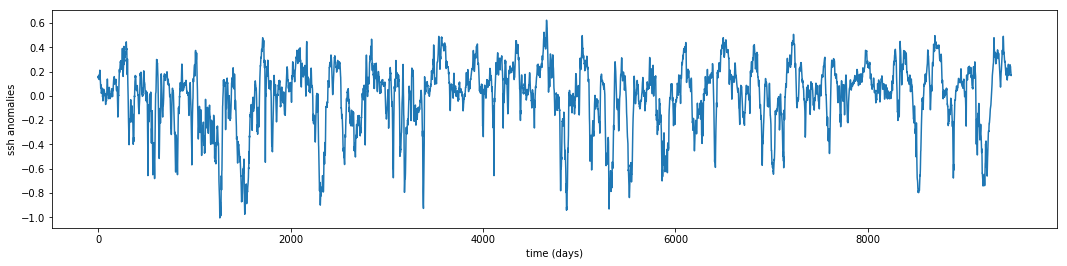

<Figure size 432x288 with 0 Axes>

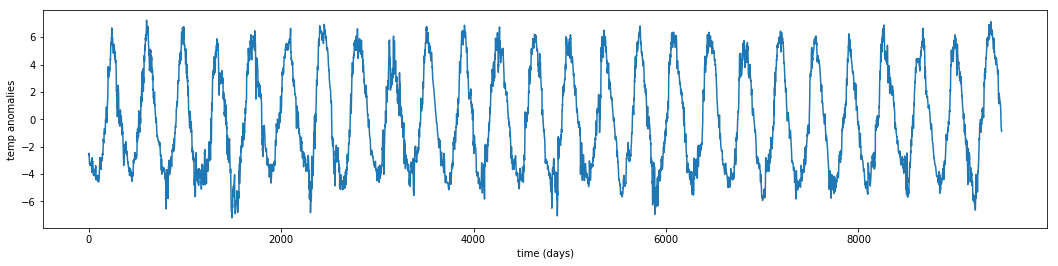

In [197]:
time0 = time - time[0] # make time start at 0

# subtract time means
ssh_a = ssh - np.mean(ssh)
temp_a = temp - np.mean(temp)

plt.figure(figsize=(18,4));
plt.plot(time0, ssh_a);
plt.xlabel('time (days)'); plt.ylabel('ssh anomalies')
plt.figure();
plt.figure(figsize=(18,4));
plt.plot(time0, temp_a);
plt.xlabel('time (days)'); plt.ylabel('temp anomalies')

We want to de-trend the temperature data. I'm not sure what the best way to do that is. I just did it by eye

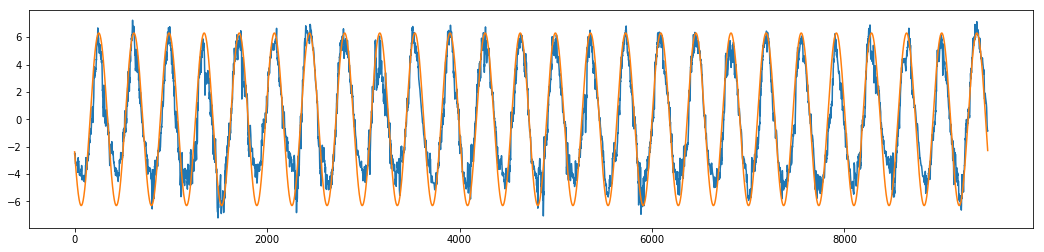

<Figure size 432x288 with 0 Axes>

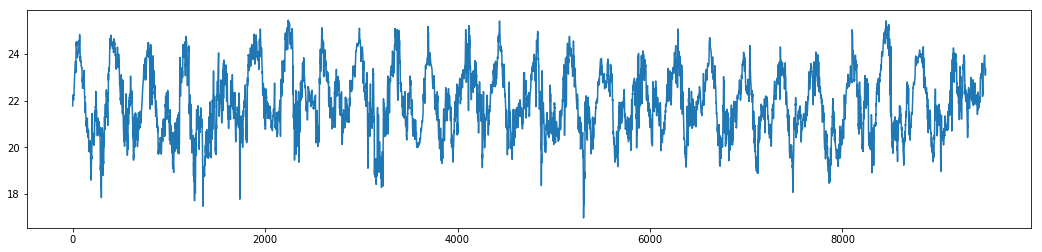

In [191]:
trend = 6.3*np.sin(2*np.pi*(time0-160)/365)
plt.figure(figsize=(18,4));
plt.plot(time0, temp_a);
plt.plot(time0, trend);

# plot de-trended data
temp_det = temp - trend
plt.figure()
plt.figure(figsize=(18,4));
plt.plot(time0, temp_det);

ii) Plotting the PDFs and power spectra of the time series

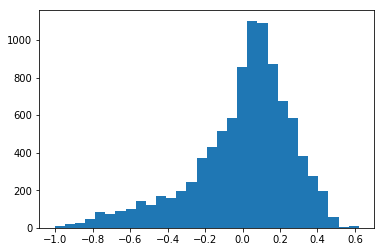

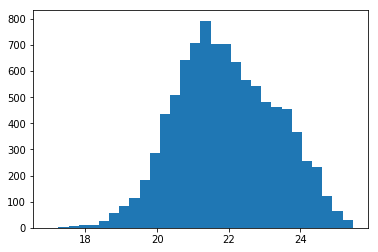

In [206]:
plt.hist(ssh-np.mean(ssh), bins=30);
plt.figure()
plt.hist(temp_det, bins=30);

The power spectrum

(1e-10, 1000.0)

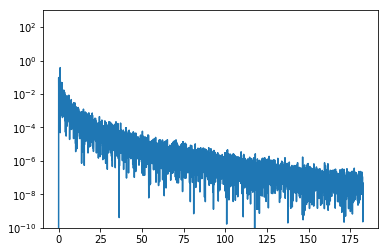

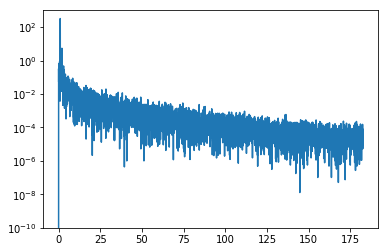

In [157]:
freq_ssh, ps_ssh = signal.periodogram(ssh, fs=365)
freq_temp, ps_temp = signal.periodogram(temp, fs=365)
plt.semilogy(freq_ssh, ps_ssh)
plt.ylim([1e-10,1e3])
plt.figure()
plt.semilogy(freq_temp, ps_temp)
plt.ylim([1e-10,1e3])

iii) We have to solve the PDE
$$ \lambda \frac{\partial}{\partial x}(xp(x)) + \frac{\partial^2}{\partial x^2}\left( \frac{(\mu+\nu x)^2}{2}p(x)\right) = 0 $$
Integrate both sides
$$ \lambda xp(x) = -\frac{\partial}{\partial x}\left( \frac{(\mu+\nu x)^2}{2}p(x)\right)$$
Expand the right hand side
$$ \lambda xp(x) = -\frac{(\mu+\nu x)^2}{2}\frac{\partial p}{\partial x} + (\mu+\nu x)p(x)$$

iv) If we set $\nu=0$ then we just have the Orstein Uhlenbeck process
$$dX_t = \lambda X_tdt+\mu dW_t$$
which has covaraince $C(t) = -\frac{\mu^2}{2\lambda} e^{\lambda t}$

We can estimate $C(0)$ and $C(1)$ from the data. Then we have
$$\lambda = -\log\left(\frac{C(0)}{C(1)}\right)$$
and 
$$\mu = \sqrt{-2\lambda C(0)}$$

In [204]:
C1 = np.mean(ssh_a[1:]*ssh_a[:-1])
C0 = np.var(ssh_a)
lambda_hat = -np.log(C0/C1)
mu_hat = np.sqrt(-2*lambda_hat*C0)